## Motivation

The discrete Fourier transform (DFT) is a transformation that converts a signal from its original domain (e.g., time or space) into a [frequency domain](https://en.wikipedia.org/wiki/Frequency_domain).
The DFT has widespread applicability (e.g., data compression, filtering, partial differential equations, etc.).
However, if the DFT is computed naively, the amount of work required to transform a signal with $n$ elements is $O(n^2)$ [FLOPs](https://en.wikipedia.org/wiki/FLOPS).

A fast Fourier transform (FFT) is any one of a family of algorithms that can compute the DFT in $O(n \lg n)$ FLOPs.
The widespread adoption of the DFT is, without a doubt, due to the FFT.

This article introduces the theory of the DFT and FFT and gives some examples in Python.

## Notation

$i$ denotes the [imaginary unit](https://en.wikipedia.org/wiki/Imaginary_unit).
The [complex conjugate](https://en.wikipedia.org/wiki/Complex_conjugate) of a complex number $z$ is denoted $z^\dagger$.

Throughout, this article, we fix our choice of $n$ and work with the complex vector space $\mathbb{C}^n$.
When the vector space is not made explicit in writing, it should be assumed that it is this one.
The [conjugate transpose](https://en.wikipedia.org/wiki/Conjugate_transpose) $\boldsymbol{z}^\mathrm{H}$ of a complex vector or matrix $\boldsymbol{z}$ is obtained by taking the ordinary [transpose](https://en.wikipedia.org/wiki/Transpose) and conjugating each entry.
An inner product is obtained by defining $\langle \boldsymbol{u}, \boldsymbol{v} \rangle = \boldsymbol{v}^{\mathrm{H}} \boldsymbol{u}$.
The induced norm is $|\boldsymbol{u}| = \sqrt{\langle \boldsymbol{u}, \boldsymbol{u} \rangle}$.

The [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) $\delta_{jj^\prime}$ is defined to be one whenever $j = j^\prime$ and zero otherwise.

## Discrete Fourier Transform

### Roots of unity

**Definition (Roots of unity).**
*A complex number $z$ satisfying $z^n = 1$ is called an $n$-th root of unity.*

**Lemma.**
*If $z$ is an $n$-th root of unity, so too is $z^u$ for any complex number $u$.*

*Proof*.
$z^u = (z^u)^n = z^{nu} = (z^n)^u = 1^u = 1.$

For the remainder, let $\omega = \exp(-2 \pi i / n)$.

**Corollary.**
$\omega^0, \ldots, \omega^{n - 1}$ are the only $n$-th roots of unity.

*Proof*.
It's readily verified by direct computation that $\omega^0, \ldots, \omega^{n - 1}$ are distinct $n$-th roots of unity.
Uniqueness follows from the [fundamental theorem of algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra) applied to $z^n - 1$.

**Lemma.**
*Let $n$ be a positive integer and $z \neq 1$ be an $n$-th root of unity.
Then $z^0 + \cdots + z^{n - 1} = 0$.*

*Proof*.
The sum is a (finite) geometric series and hence $(1 - z) (z^0 + \cdots + z^{n - 1}) = 1 - z^n$, from which the desired result follows.

### Forward and inverse transforms

**Theorem.**
*Let
\begin{equation}
    \boldsymbol{f}^{(j)}
    = \frac{1}{\sqrt{n}} ( \omega^0, \omega^j, \omega^{2j}, \ldots, \omega^{(n - 1)j} ).
\end{equation}
Then, the vectors $\boldsymbol{f}^{(0)}, \ldots, \boldsymbol{f}^{(n - 1)}$* form an orthonormal basis for $\mathbb{C}^n$.

*Proof*.
Let $j$ and $j^\prime$ be nonnegative integers strictly smaller than $n$.
By the previous lemma,
\begin{equation}
      n \left \langle \boldsymbol{f}^{(j)}, \boldsymbol{f}^{(j^\prime)} \right \rangle
    = \omega^{(j - j^\prime) \cdot 0} + \cdots + \omega^{(j - j^\prime) \cdot (n - 1)}
    = n \delta_{jj^\prime}
\end{equation}
as desired.

The above establishes that the matrix $F$ whose rows are $\boldsymbol{f}^{(0)}, \ldots, \boldsymbol{f}^{(n - 1)}$ is [unitary](https://en.wikipedia.org/wiki/Unitary_matrix).
The matrix $F$ is called the *forward transform*.
Because this matrix is unitary, its conjugate transpose $F^{\mathrm{H}}$ is its inverse.
As such, we call the conjugate transpose the *inverse transform*.

*Remark*.
In the above, we used the scaling factor $n^{-1 / 2}$ to ensure that the matrix F was unitary, simplifying mathematical discussion.
The [NumPy definitions of forward and inverse transforms](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft) do not use the same scaling factor (in particular, `numpy.fft.fft` uses $n^{1 / 2} F$ and hence the corresponding inverse transform `numpy.fft.ifft` uses $n^{-1 / 2} F^\mathrm{H}$ to ensure that the two functions are inverses of one another).
Software libraries have their own conventions when it comes to the scaling factors for forward and inverse transforms, so it’s best to proceed carefully!

For the remainder, we employ the convention that if $\boldsymbol{z}$ is a vector, then the uppercase symbol $\boldsymbol{Z}$ is its forward transform.
That is, $\boldsymbol{Z} = F \boldsymbol{z}$.

### Some immediate results

**Theroem (Plancherel theorem).**
*Let $\boldsymbol{u}$ and $\boldsymbol{v}$ be vectors.
Then, $\langle \boldsymbol{u}, \boldsymbol{v} \rangle = \langle \boldsymbol{U}, \boldsymbol{V} \rangle$.*

*Proof*.
$\langle \boldsymbol{U}, \boldsymbol{V} \rangle = \langle F \boldsymbol{v}, F \boldsymbol{v} \rangle = \boldsymbol{v}^{\mathrm{H}} F^{\mathrm{H}} F \boldsymbol{u} = \boldsymbol{v}^{\mathrm{H}} \boldsymbol{u} = \langle \boldsymbol{u}, \boldsymbol{v} \rangle$.

**Corollary (Parseval's theorem).**
*Let $\boldsymbol{u}$ be a vector. Then, $|\boldsymbol{u}| = |\boldsymbol{U}|$.*

The above result simply states that the original vector and its transform have the same Euclidean norm.

### Convolution

For integers $a$ and $b$ with $b$ nonnegative, denote $a \% b$ the least nonnegative residue of $a$ modulo $b$ (i.e., the usual definition of the operator `%` in many programming languages).
For a vector $\boldsymbol{u}$ with $n$ entries, we introduce the indexing convention $z_j = z_{j \% n}$ whenever $j$ is negative or at least as large $n$.

**Definition (Circular convolution).**
*The circular convolution of vectors $\boldsymbol{u}$ and $\boldsymbol{v}$ is a vector $\boldsymbol{u} \star \boldsymbol{v}$ with entries $(\boldsymbol{u} \star \boldsymbol{v})_j = u_0 v_{j - 0} + \cdots + u_{n - 1} v_{j - (n - 1)}$.*

Denote by $\odot$ the [element-wise product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)).

**Theorem (Convolution theorem).**
Let $\boldsymbol{u}$ and $\boldsymbol{v}$ be vectors.
Then, $F (\boldsymbol{u} \star \boldsymbol{v}) = \sqrt{n} (\boldsymbol{U} \odot \boldsymbol{V})$.

The above theorem tells us that the convolution of vectors $\boldsymbol{u}$ and $\boldsymbol{v}$ can be computed by

1. computing the DFTs $\boldsymbol{U}$ and $\boldsymbol{V}$,
2. multiplying these element-wise to get $\boldsymbol{Z} = \boldsymbol{U} \odot \boldsymbol{V}$, and
3. computing the inverse Fourier transform of $\sqrt{n} \boldsymbol{Z}$.

Similar results can be established for the circular [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation).

### Real signals

In practice, the input to the forward transform is often a real signal (i.e., a vector in $\mathbb{R}^n$).
It is useful to derive some facts about such signals.

**Theorem (Conjugate symmetry).**
*Let $\boldsymbol{x}$ be a vector in $\mathbb{R}^n$.
Then, $X_j^\dagger = X_{n - j}$.*

*Proof*.
First, note that
$\boldsymbol{X}^{\mathrm{H}}=(F\boldsymbol{x})^{\mathrm{H}}=\boldsymbol{x}^{\intercal}F^{\mathrm{H}}=((F^{\mathrm{H}})^{\intercal}\boldsymbol{x})^{\intercal}$.
Using the fact that $(\omega^{kj})^{\dagger}=\omega^{-kj}=\omega^{k(n-j)}$, the $j$-th row of $(F^{\mathrm{H}})^{\intercal}$ is $f^{(n-j)}$, from which the result follows.

The above tells us that for a real input $\boldsymbol{x}$, we need only compute the first $1 + \lfloor n / 2 \rfloor$ coordinates of $\boldsymbol{X}$.

*Remark*.
The [NumPy function `numpy.fft.rfft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html#numpy.fft.rfft) takes advantage of this fact.

But what if we only have access to a "black box" function that computes the forward transform?
Can we still save on computation? The answer is provided by the corollary below.

**Corollary.**
*Let $\boldsymbol{x}$ and $\boldsymbol{y}$ be two vectors in $\mathbb{R}^n$.
Let $\boldsymbol{z} = \boldsymbol{x} + i\boldsymbol{y}$.
Then, $2 X_j = Z_j + Z_{n - j}^\dagger$ and $2 i Y_j = Z_j - Z_{n - j}^\dagger$.*

In other words, the DFT of two real inputs $\boldsymbol{x}$ and $\boldsymbol{y}$ can be computed by

1. creating a complex signal $\boldsymbol{z}$ whose real part is $\boldsymbol{x}$ and whose complex part is $\boldsymbol{y}$,
2. computing the DFT $\boldsymbol{Z}$, and
3. retrieving the individual DFTs $\boldsymbol{X}$ and $\boldsymbol{Y}$ by the above formulas.

In [7]:
%load_ext lab_black

In [82]:
import numpy as np


def fft_of_two_real_signals(x: np.ndarray, y: np.ndarray):
    """Computes the FFT of two real signals using a single complex FFT.

    Parameters
    ----------
    x: A real NumPy vector.
    y: A real NumPy vector.

    Returns
    -------
    X: The FFT of x.
    Y: The FFT of y.
    """
    z = x + 1j * y
    Z = np.fft.fft(z)
    Z_reverse_conj = np.conjugate(np.concatenate([[Z[0]], np.flip(Z[1:])]))
    X = (Z + Z_reverse_conj) * 0.5
    Y = (Z_reverse_conj - Z) * 0.5j
    return X, Y

In [62]:
np.random.seed(1)
n = 10
x = np.random.randn(n)
y = np.random.randn(n)
X = np.fft.fft(x)
Y = np.fft.fft(y)
X_, Y_ = fft_of_two_real_signals(x, y)
np.testing.assert_allclose(X, X_)
np.testing.assert_allclose(Y, Y_)

## Fast Fourier transform

The [Cooley-Tukey algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) is the most common FFT algorithm.
It re-expresses the DFT of an arbitrary composite size $n = ab$ in terms of smaller DFTs of sizes $a$ and $b$.

### Radix-2 algorithm

Assuming $n$ is even, the radix-2 algorithm corresponds to taking $a = b = n /2$.
The motivation comes from notating that
\begin{equation}
    \sqrt{n}X_{k}
    =\sum_{j=0}^{n-1}\omega^{jk}x_{j}
    =\sum_{j=0}^{n/2-1}\omega^{2jk}x_{2j}+\omega^{k}\sum_{j=0}^{n/2-1}\omega^{2jk}x_{2j+1}
\end{equation}
and hence $X_k = E_k + \omega^k O_k$ where $\boldsymbol{E}$ and $\boldsymbol{O}$ are DFTs of the even and odd parts of the original signal $\boldsymbol{x}$.
By expressing this relationship recursively, we obtain a natural $O(n \lg n)$ algorithm to compute the DFT.

## Image compression

Image compression is one possible application of the FFT.
It can be achieved by

1. transforming the image into the frequency domain,
2. dropping high-frequency components, and
3. saving the result.

To view the image, one must inverse transform back to the original domain.

Let's try it on an example image.

*Remark*. There are much better ways to compress images; the code below is purely demonstrational.

In [198]:
%load_ext lab_black

In [217]:
from io import BytesIO
import requests

from typing import List, Tuple
import sys

from PIL import Image, ImageOps
import numpy as np

Lossy = Tuple[int, int, int, int, float, np.ndarray]


def _masks(height: int, width: int, freq: float) -> Tuple[np.ndarray, np.ndarray]:
    i = np.fft.fftfreq(height) <= freq
    j = np.fft.rfftfreq(width) <= freq
    return i, j


def image_to_lossy(image: Image, freq: float) -> Lossy:
    channel = np.array(image) / 255.0
    n_bytes = np.prod(channel.shape)
    height, width = channel.shape
    channel = np.fft.rfft2(channel)
    rows, cols = channel.shape
    i, j = _masks(height, width, freq)
    channel = channel[np.ix_(i, j)]
    channel = channel.astype(np.cfloat)
    n_bytes_compressed = np.prod(channel.shape) * 8  # 8 bytes per cfloat
    ratio = n_bytes_compressed / n_bytes
    sys.stderr.write(f"Compressed to {ratio * 100:.2f}% of original size\n")
    return height, width, rows, cols, freq, channel


def image_from_lossy(lossy: Lossy) -> Image:
    height, width, rows, cols, freq, lossy_channel = lossy
    i, j = _masks(height, width, freq)
    channel = np.zeros([rows, cols], dtype=np.cfloat)
    channel[np.ix_(i, j)] = lossy_channel
    channel = np.fft.irfft2(channel)
    channel = np.real(channel)
    channel = (channel * 255).astype(np.uint8)
    return Image.fromarray(channel)


url = "https://pixnio.com/free-images/2018/06/29/2018-06-29-23-01-01-1200x675.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = ImageOps.grayscale(image)

lossy = image_to_lossy(image, freq=0.1)
lossy_image = image_from_lossy(lossy)

Compressed to 48.40% of original size


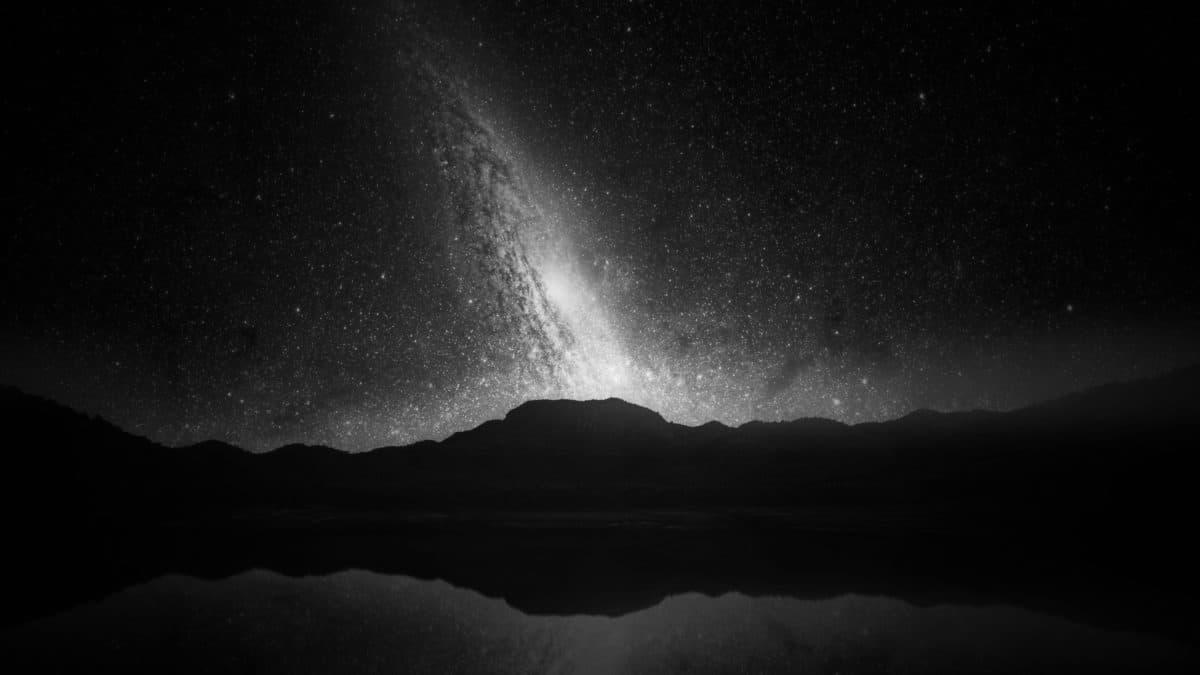

In [218]:
image

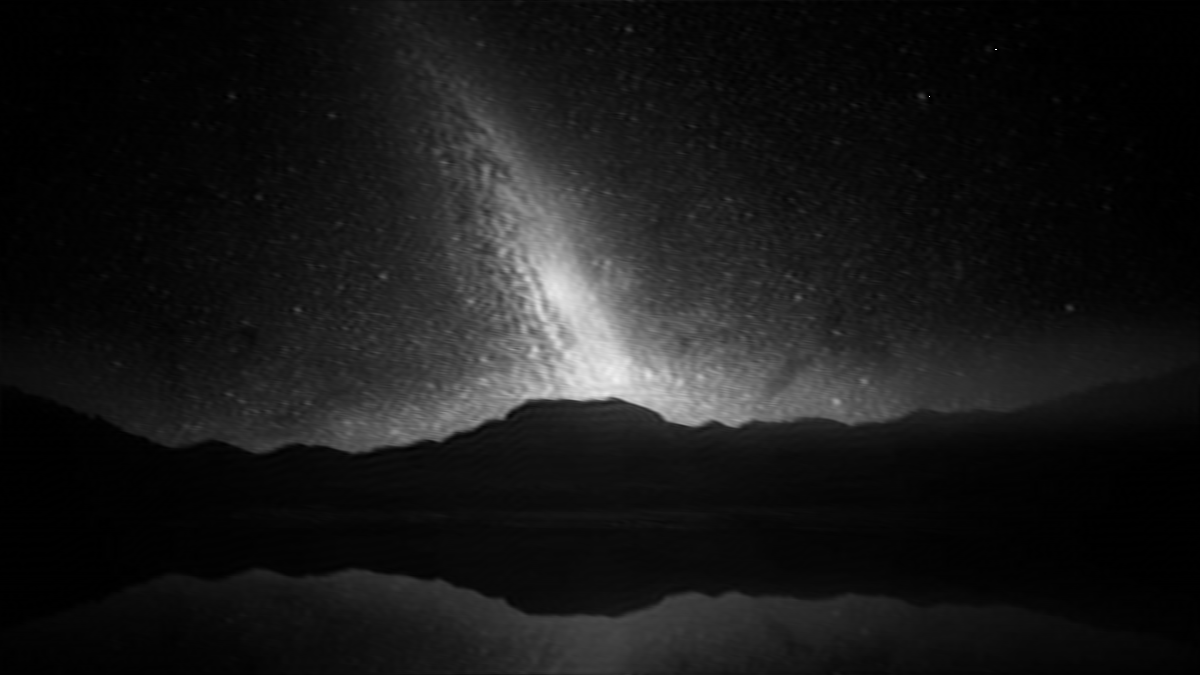

In [219]:
lossy_image